In [1]:
from Data import *

import pandas as pd
import string
import random

import torch
from torch import optim
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.utils.rnn import  pack_padded_sequence, pad_packed_sequence
from torchsummary import summary

import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import numpy as np
import tqdm
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_name = 'Lab4_seq2seq_vae_lstm_KL_cond.pt'
loss_file = "Lab4_seq2seq_vae_lstm_KL_cond_loss.npz"
print('Using {} device'.format(device))

Using cuda device


In [2]:
sp = 0
tp = 1
pg = 2
p = 3

def split_data(data):
    split_data = []
    for string in data:
        split_space = string.split()
        for i, word in enumerate(split_space):
            split_data.append(word)
    return split_data

def y_train_make(n):
    sp = 0
    tp = 1
    pg = 2
    p = 3
    np_sp = np.array([sp])
    np_tp = np.array([tp])
    np_pg = np.array([pg])
    np_p = np.array([p])
    y = []
    for i in range(n):
        y.append(np_sp)
        y.append(np_tp)
        y.append(np_pg)
        y.append(np_p)
    return np.array(y)

def src_trg_split(data):
    src = []
    trg = []
    for i in range(0, len(data), 2):
        src.append(data[i])
        trg.append(data[i+1])
    return np.array(src), np.array(trg)

In [3]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

train_data = np.squeeze(pd.read_csv('train.txt', header=None))

y_train = y_train_make(len(train_data))

def to_one_hot(label):
    one_hot =  np.zeros((len(label), 4))
    one_hot[np.arange(len(label)), label[:, 0]] = 1
    return one_hot
    
y_train = to_one_hot(y_train)
train_data = split_data(train_data)
train_loader = DataTransformer(train_data, y_train, use_cuda=True)

In [4]:
test_data = np.squeeze(pd.read_csv('test.txt', header=None))
test_data = split_data(test_data)
test_data = np.array(test_data)
src, trg = src_trg_split(test_data)
test_src = []
test_trg = []

for word in src:
    test_src.append(train_loader.vocab.sequence_to_indices(word, add_eos=True))

for word in trg:
    test_trg.append(train_loader.vocab.sequence_to_indices(word, add_eos=True))
"""
sp -> p
sp -> pg
sp -> tp
sp -> tp
p  -> tp
sp -> pg
p  -> sp
pg -> sp
pg -> p
pg -> tp
"""
test_c_src = np.array([sp, sp, sp, sp, p, sp, p, pg, pg, pg]).reshape(-1, 1)
test_c_trg = np.array([p, pg, tp, tp, tp, pg, sp, sp, p, tp]).reshape(-1, 1)
test_c_src = Variable(torch.LongTensor(to_one_hot(test_c_src))).to(device)
test_c_trg = Variable(torch.LongTensor(to_one_hot(test_c_trg))).to(device)

In [5]:
def test_eval(model, epoch):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():    
        src_c = test_src
        trg_c = test_trg
        optimizer.zero_grad()            
        output = model(src, trg, src_c, trg_c, 0) #turn off teacher forcing
        loss = criterion(output[1:].view(-1, output.shape[-1]), trg[1:].view(-1))
        
        if epoch % 10 == 0:
            print("=========show testing result=========")
            for i in range(output.shape[-1]):
                show_result(trg, output, i)
                print()
            
        return loss
    
def show_result(target, output, index):
    print("Ground true: ", end="")
    for i in range(max_len):
        tmp = trg[index, i]
        if tmp == 1:
            break
        elif tmp == 0:
            continue
        print(chr(trg[index, i]-7+ord('a')), end="")
    
    print(" Predict: ", end="")
    for i in range(max_len):
        print(chr(np.argmax(o[index, i, 3:])-4+ord('a')), end="")

In [6]:
class Encoder(nn.Module):

    def __init__(self, vocab_size, embedding_size, output_size, lat_dim):
        """Define layers for a vanilla rnn encoder"""
        super(Encoder, self).__init__()

        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, output_size)
        
        self.hidden2mean = nn.Linear(output_size, lat_dim)
        self.hidden2logv = nn.Linear(output_size, lat_dim)
        
        self.cell2mean = nn.Linear(output_size, lat_dim)
        self.cell2logv = nn.Linear(output_size, lat_dim)

    def forward(self, input_seqs, input_lengths, label, hidden=None, cell=None):
        embedded = self.embedding(input_seqs)
        packed = pack_padded_sequence(embedded, input_lengths)
        label = label.view(1, label.shape[0], label.shape[1])
        hidden = torch.cat([hidden, label], dim=2)
        cell = torch.cat([cell, label], dim=2)
        packed_outputs, (hidden, cell) = self.lstm(packed, (hidden, cell))
        outputs, output_lengths = pad_packed_sequence(packed_outputs)
        
        hidden_means = self.hidden2mean(hidden)
        hidden_logv = self.hidden2logv(hidden)
        
        cell_means = self.cell2mean(cell)
        cell_logv = self.cell2logv(cell)
        
        return outputs, hidden_means, hidden_logv, cell_means, cell_logv
    
    def initHidden(self, batch_size):
        return torch.zeros([1, batch_size, 256-4]) # (D * num_layers, batch_size, H_out) 

In [7]:
class Decoder(nn.Module):

    def __init__(self, hidden_size, output_size, lat_dim, max_length, teacher_forcing_ratio, sos_id, use_cuda):
        """Define layers for a vanilla rnn decoder"""
        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.latent2hidden = nn.Linear(lat_dim, hidden_size-4)
        self.latent2cell = nn.Linear(lat_dim, hidden_size-4)
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=-1)  # work with NLLLoss = CrossEntropyLoss

        self.max_length = max_length
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.sos_id = sos_id
        self.use_cuda = use_cuda

    def forward_step(self, inputs, hidden, cell):
        # inputs: (time_steps=1, batch_size)
        batch_size = inputs.size(1)
        embedded = self.embedding(inputs)
        embedded.view(1, batch_size, self.hidden_size)  # S = T(1) x B x N
        rnn_output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # S = T(1) x B x H
        rnn_output = rnn_output.squeeze(0)  # squeeze the time dimension
        output = self.log_softmax(self.out(rnn_output))  # S = B x O
        return output, hidden, cell

    def forward(self, context_vector, decoder_cell, targets):

        # Prepare variable for decoder on time_step_0
        target_vars, target_lengths = targets
        batch_size = context_vector.size(1)
        decoder_input = Variable(torch.LongTensor([[self.sos_id] * batch_size]))

        # Pass the context vector
        decoder_hidden = context_vector

        max_target_length = max(target_lengths)
        decoder_outputs = Variable(torch.zeros(
            max_target_length,
            batch_size,
            self.output_size
        ))  # (time_steps, batch_size, vocab_size)

        if self.use_cuda:
            decoder_input = decoder_input.cuda()
            decoder_outputs = decoder_outputs.cuda()

        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False

        # Unfold the decoder RNN on the time dimension
        for t in range(max_target_length):
            decoder_outputs_on_t, decoder_hidden, decoder_cell = self.forward_step(decoder_input, decoder_hidden, decoder_cell)
            decoder_outputs[t] = decoder_outputs_on_t
            if use_teacher_forcing:
                decoder_input = target_vars[t].unsqueeze(0)
            else:
                decoder_input = self._decode_to_index(decoder_outputs_on_t)

        return decoder_outputs, decoder_hidden, decoder_cell

    def evaluate(self, context_vector, decoder_cell):
        batch_size = context_vector.size(1) # get the batch size
        decoder_input = Variable(torch.LongTensor([[self.sos_id] * batch_size]))
        decoder_hidden = context_vector

        decoder_outputs = Variable(torch.zeros(
            self.max_length,
            batch_size,
            self.output_size
        ))  # (time_steps, batch_size, vocab_size)

        if self.use_cuda:
            decoder_input = decoder_input.cuda()
            decoder_outputs = decoder_outputs.cuda()

        # Unfold the decoder RNN on the time dimension
        for t in range(self.max_length):
            decoder_outputs_on_t, decoder_hidden, decoder_cell = self.forward_step(decoder_input, decoder_hidden, decoder_cell)
            decoder_outputs[t] = decoder_outputs_on_t
            decoder_input = self._decode_to_index(decoder_outputs_on_t)  # select the former output as input

        return self._decode_to_indices(decoder_outputs)

    def _decode_to_index(self, decoder_output):
        """
        evaluate on the logits, get the index of top1
        :param decoder_output: S = B x V or T x V
        """
        value, index = torch.topk(decoder_output, 1)
        index = index.transpose(0, 1)  # S = 1 x B, 1 is the index of top1 class
        if self.use_cuda:
            index = index.cuda()
        return index

    def _decode_to_indices(self, decoder_outputs):
        """
        Evaluate on the decoder outputs(logits), find the top 1 indices.
        Please confirm that the model is on evaluation mode if dropout/batch_norm layers have been added
        :param decoder_outputs: the output sequence from decoder, shape = T x B x V 
        """
        decoded_indices = []
        batch_size = decoder_outputs.size(1)
        decoder_outputs = decoder_outputs.transpose(0, 1)  # S = B x T x V

        for b in range(batch_size):
            top_ids = self._decode_to_index(decoder_outputs[b])
            decoded_indices.append(top_ids.data[0].cpu().numpy())
        return decoded_indices

In [8]:
class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, inputs, targets, label):
        # variables
        input_vars, input_lengths = inputs
        batch_size = input_vars.shape[1]
        encoder_hidden = self.encoder.initHidden(batch_size).to(device)
        encoder_cell = self.encoder.initHidden(batch_size).to(device)
        
        # encoder
        encoder_outputs, hidden_means, hidden_logv, cell_means, cell_logv = \
            self.encoder.forward(input_vars, input_lengths, label, hidden=encoder_hidden, cell=encoder_cell)  

        # reparaterization trick
        encoder_hidden = self.reparaterization_trick(hidden_means, hidden_logv)
        encoder_hidden = self.decoder.latent2hidden(encoder_hidden)
        encoder_cell = self.reparaterization_trick(cell_means, cell_logv)
        encoder_cell = self.decoder.latent2cell(encoder_cell)
        encoder_hidden = torch.cat([encoder_hidden, label.view(1, label.shape[0], label.shape[1])], dim=2)
        encoder_cell = torch.cat([encoder_cell, label.view(1, label.shape[0], label.shape[1])], dim=2)
        
        # decoder
        decoder_outputs, decoder_hidden, decoder_cell = self.decoder.forward(context_vector=encoder_hidden, 
                                                               decoder_cell=encoder_cell, targets=targets)
        
        return decoder_outputs, decoder_hidden, hidden_means, hidden_logv, cell_means, cell_logv

    def evaluate(self, inputs, src_label, trg_label):
        # variables
        input_vars, input_lengths = inputs
        batch_size = input_vars.shape[1]
        encoder_hidden = self.encoder.initHidden(batch_size).to(device)
        encoder_cell = self.encoder.initHidden(batch_size).to(device)
        
        # encoder
        encoder_outputs, hidden_means, hidden_logv, cell_means, cell_logv = \
            self.encoder.forward(input_vars, input_lengths, src_label, hidden=encoder_hidden, cell=encoder_cell)  

        # reparaterization trick
        encoder_hidden = self.reparaterization_trick(hidden_means, hidden_logv)
        encoder_hidden = self.decoder.latent2hidden(encoder_hidden)
        encoder_cell = self.reparaterization_trick(cell_means, cell_logv)
        encoder_cell = self.decoder.latent2cell(encoder_cell)
        encoder_hidden = torch.cat([encoder_hidden, trg_label.view(1, trg_label.shape[0], trg_label.shape[1])], dim=2)
        encoder_cell = torch.cat([encoder_cell, trg_label.view(1, trg_label.shape[0], trg_label.shape[1])], dim=2)
        
        # decoder
        decoded_sentence = self.decoder.evaluate(context_vector=encoder_hidden, decoder_cell=encoder_cell)
        
        return decoded_sentence
    
    def reparaterization_trick(self, mean, logv):
        std = torch.exp(0.5*logv)
        eps = torch.randn_like(std)
        return  mean + eps * std

In [9]:
class Trainer(object):

    def __init__(self, model, data_transformer, label, learning_rate, use_cuda, checkpoint_name,
                 teacher_forcing_ratio=1.0, kl_weight=0):

        self.model = model
        self.checkpoint_name = checkpoint_name
        self.total_iter = 0
        
        # save list
        self.entropy = []
        self.kld = []
        self.kl_weight_list = []
        self.teacher_forcing_ratio_list = []
        self.score = []
        
        # init hyperparameters
        self.kl_weight = kl_weight
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.kl_weight_list.append(self.kl_weight)
        self.teacher_forcing_ratio_list.append(self.teacher_forcing_ratio)
        
        # record some information about dataset
        self.data_transformer = data_transformer
        self.label = label
        self.vocab_size = self.data_transformer.vocab_size
        self.PAD_ID = self.data_transformer.PAD_ID
        self.use_cuda = use_cuda
        
        # optimizer setting
        self.learning_rate = learning_rate
        self.optimizer= torch.optim.Adam(self.model.parameters(), lr=learning_rate)
#         self.optimizer= torch.optim.SGD(self.model.parameters(), lr=learning_rate)
        self.criterion = torch.nn.NLLLoss(ignore_index=self.PAD_ID, reduction='mean')

    def train(self, num_epochs, batch_size, pretrained=False):

        if pretrained:
            self.load_model()

        step = 0
        self.model.encoder.train()
        self.model.decoder.train()
        for epoch in range(0, num_epochs):
            mini_batches = self.data_transformer.mini_batches(batch_size=batch_size)
            for input_batch, target_batch, label_batch in mini_batches:
                self.total_iter += 1
                self.optimizer.zero_grad()
                self.model.decoder.teacher_forcing_ratio = self.teacher_forcing_ratio
                decoder_outputs, decoder_hidden, hidden_means, hidden_logv, cell_means, cell_logv = \
                    self.model(input_batch, target_batch, label_batch)

                # calculate the loss and back prop.
                cur_loss = self.get_loss(decoder_outputs, target_batch[0])
                kl_loss = self.kl_weight * self.get_kl_loss(hidden_means, hidden_logv)+\
                            self.kl_weight* self.get_kl_loss(cell_means, cell_logv)
                loss = cur_loss + kl_loss
                
                self.entropy.append(cur_loss.item())
                self.kld.append(kl_loss.item())
                
                # logging
                step += 1
                if step % 50 == 0:
                    print("Step:", step, "char-loss: ", loss.item())
                    print("KL_weight: ", self.kl_weight, "teacher_forcing_ratio: ", self.teacher_forcing_ratio)
                    self.save_model()
                loss.backward()

                # optimize
                self.optimizer.step()
                
                # update hyperparameters
                self.kl_weight = self.get_kl_weight(self.kl_weight)
                self.teacher_forcing_ratio = self.get_teacher_forcing_ratio(self.teacher_forcing_ratio)
                self.kl_weight_list.append(self.kl_weight)
                self.teacher_forcing_ratio_list.append(self.teacher_forcing_ratio)

        self.save_model()

    def get_loss(self, decoder_outputs, targets):
        b = decoder_outputs.size(1)
        t = decoder_outputs.size(0)
        targets = targets.contiguous().view(-1)  # S = (B*T)
        decoder_outputs = decoder_outputs.view(b * t, -1)  # S = (B*T) x V
        return self.criterion(decoder_outputs, targets)
    
    def get_kl_loss(self, mean, logvar):
        result = -0.5 * torch.sum(logvar - torch.pow(mean, 2) - torch.exp(logvar) + 1, 1)
        return result.mean()
    
    def get_kl_weight(self, kl_weight):
#         return 0
        if self.total_iter % 10000 == 0:
            return 0
        else:
            return min(1, kl_weight + 0.0002)

    def get_teacher_forcing_ratio(self, teacher_forcing_ratio):
#         return teacher_forcing_ratio
        return 1
#         return max(0, teacher_forcing_ratio - 0.0000001)

    def save_model(self):
        torch.save(self.model.state_dict(), self.checkpoint_name)
        np.savez(loss_file, entropy=self.entropy, kld=self.kld, kl_weight=self.kl_weight_list,\
                 teacher_forcing_ratio=self.teacher_forcing_ratio_list, score=self.score)
        print("Model has been saved as %s.\n" % self.checkpoint_name)

    def load_model(self):
        self.model.load_state_dict(torch.load(self.checkpoint_name, map_location=device))
        load_file = np.load(loss_file)
        self.entropy = load_file['entropy'].tolist()
        self.kld = load_file['kld'].tolist()
        self.kl_weight_list = load_file['kl_weight'].tolist()
        self.teacher_forcing_ratio_list = load_file['teacher_forcing_ratio'].tolist()
        self.score = load_file['score'].tolist()
        print("Pretrained model has been loaded.\n")

    def evaluate(self, words, src_label, trg_label):
        # make sure that words is list
        if type(words) is not list:
            words = [words]

        # transform word to index-sequence
        eval_var = self.data_transformer.evaluation_batch(words=words)
        decoded_indices = self.model.evaluate(eval_var, src_label, trg_label)
        results = []
        for indices in decoded_indices:
            results.append(self.data_transformer.vocab.indices_to_sequence(indices))
        return results
    
    def compute_bleu(self, output, reference):
        cc = SmoothingFunction()
        if len(reference) == 3:
            weights = (0.33,0.33,0.33)
        else:
            weights = (0.25,0.25,0.25,0.25)
        return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)

In [10]:
# define our models
encoder = Encoder(vocab_size=train_loader.vocab_size,
                         embedding_size=256,
                         output_size=256,
                         lat_dim=32).to(device)

decoder = Decoder(hidden_size=256,
                         output_size=train_loader.vocab_size,
                         lat_dim=32,
                         max_length=train_loader.max_length,
                         teacher_forcing_ratio=1.,
                         sos_id=train_loader.SOS_ID,
                         use_cuda=True).to(device)

seq2seq = Seq2Seq(encoder=encoder,
                  decoder=decoder)

trainer = Trainer(seq2seq, train_loader, y_train, learning_rate=0.001, use_cuda=True, checkpoint_name=checkpoint_name,
                 teacher_forcing_ratio=1, kl_weight=0)

In [11]:
for epoch in tqdm.notebook.tqdm(range(100)):
    trainer.train(num_epochs=10, batch_size=128, pretrained=False)
    
    ## eval
    print("========================================Evaluating========================================")  
    total_score = 0.0
    for i in range(len(test_src)):
        word = train_loader.vocab.indices_to_sequence(test_src[i])
        trg_true = train_loader.vocab.indices_to_sequence(test_trg[i])
        results = trainer.evaluate(word, test_c_src[i].view(1, -1), test_c_trg[i].view(1, -1))[0]
        score = trainer.compute_bleu(results, trg_true)
        print("Src_true: {:>12}".format(word), "\tTrg_true:{:>12}".format(trg_true), "\tPredict: {:>12}".format(results), "\tScore: {:>8.5f}".format(score))
        total_score += score
    total_score /= len(test_src)
    trainer.score.append(total_score)
    trainer.save_model()
    print("Total score:", total_score)
    print("==========================================================================================\n")

Step: 50 char-loss:  2.1113810539245605
KL_weight:  0.0098 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  1.8443390130996704
KL_weight:  0.01979999999999999 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  1.729557752609253
KL_weight:  0.02979999999999993 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  1.657063364982605
KL_weight:  0.03979999999999987 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  1.4507811069488525
KL_weight:  0.04979999999999981 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  1.4549479484558105
KL_weight:  0.05979999999999975 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  1.3708552122116089
KL_weight:  0.0697999999999

Step: 50 char-loss:  0.907480001449585
KL_weight:  0.3217999999999972 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.9187374711036682
KL_weight:  0.3317999999999961 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8936861157417297
KL_weight:  0.341799999999995 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8780210018157959
KL_weight:  0.3517999999999939 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.9132603406906128
KL_weight:  0.3617999999999928 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.9227047562599182
KL_weight:  0.3717999999999917 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.9117106795310974
KL_weight:  0.381799

Step: 50 char-loss:  0.8446058034896851
KL_weight:  0.6337999999999628 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.9010800123214722
KL_weight:  0.6437999999999617 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.9239169359207153
KL_weight:  0.6537999999999606 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8420308232307434
KL_weight:  0.6637999999999595 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8543099761009216
KL_weight:  0.6737999999999584 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.8688593506813049
KL_weight:  0.6837999999999573 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8831890225410461
KL_weight:  0.6937

Step: 50 char-loss:  0.848832368850708
KL_weight:  0.9457999999999285 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.8874533772468567
KL_weight:  0.9557999999999274 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8645910620689392
KL_weight:  0.9657999999999263 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8417898416519165
KL_weight:  0.9757999999999252 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8607072234153748
KL_weight:  0.9857999999999241 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.8759432435035706
KL_weight:  0.995799999999923 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8775094747543335
KL_weight:  1 teache

Step: 50 char-loss:  0.9009621143341064
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.8763349652290344
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8728213310241699
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8343780636787415
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8547662496566772
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.8568330407142639
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8637417554855347
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Model has been saved 

Step: 50 char-loss:  0.8752567768096924
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.8654142618179321
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8574240803718567
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8051799535751343
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.844915509223938
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.8363373875617981
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8352059721946716
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Model has been saved a

Step: 50 char-loss:  0.8287588953971863
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.8701320886611938
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8530696034431458
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8689298629760742
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8646112084388733
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.8444454669952393
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8511845469474792
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Model has been saved 

Step: 50 char-loss:  0.8424222469329834
KL_weight:  0.1938000000000035 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.8506101965904236
KL_weight:  0.20380000000000378 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8392415642738342
KL_weight:  0.21380000000000407 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.84699547290802
KL_weight:  0.22380000000000436 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8553874492645264
KL_weight:  0.23380000000000464 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.8440812826156616
KL_weight:  0.24380000000000493 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8349982500076294
KL_weight:  0.2

Step: 50 char-loss:  0.8349738717079163
KL_weight:  0.5057999999999769 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.8258498311042786
KL_weight:  0.5157999999999758 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.858938992023468
KL_weight:  0.5257999999999747 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8506322503089905
KL_weight:  0.5357999999999736 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8513748049736023
KL_weight:  0.5457999999999725 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.8430591821670532
KL_weight:  0.5557999999999714 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8371725678443909
KL_weight:  0.56579

Step: 50 char-loss:  0.8790258169174194
KL_weight:  0.8177999999999426 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.8658756613731384
KL_weight:  0.8277999999999415 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8503990769386292
KL_weight:  0.8377999999999404 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8436117768287659
KL_weight:  0.8477999999999393 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8392291069030762
KL_weight:  0.8577999999999382 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.8486739993095398
KL_weight:  0.8677999999999371 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8581424951553345
KL_weight:  0.8777

Step: 50 char-loss:  0.8410446047782898
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.8428741693496704
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8648638129234314
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8347079753875732
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8506926894187927
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.8503135442733765
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8323854207992554
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Model has been saved 

Step: 50 char-loss:  0.8700218796730042
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.806376576423645
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8573412299156189
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8305050730705261
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8571948409080505
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.8458371162414551
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.843080461025238
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Model has been saved as

Step: 50 char-loss:  0.7824786901473999
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.8482493758201599
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8634880781173706
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8465370535850525
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8296124935150146
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.8751993179321289
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8280450105667114
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Model has been saved 

Step: 50 char-loss:  0.9143446683883667
KL_weight:  0.06579999999999983 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.8564578294754028
KL_weight:  0.07580000000000012 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8870803713798523
KL_weight:  0.0858000000000004 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8623485565185547
KL_weight:  0.09580000000000069 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8651533722877502
KL_weight:  0.10580000000000098 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.8481231331825256
KL_weight:  0.11580000000000126 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8812190294265747
KL_weight:  0

Step: 50 char-loss:  0.8415783643722534
KL_weight:  0.37779999999999103 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.8436053395271301
KL_weight:  0.38779999999998993 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8142979741096497
KL_weight:  0.39779999999998883 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8464541435241699
KL_weight:  0.40779999999998773 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8399049043655396
KL_weight:  0.4177999999999866 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.8609011769294739
KL_weight:  0.4277999999999855 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8450824022293091
KL_weight:  0.

Step: 50 char-loss:  0.835685133934021
KL_weight:  0.6897999999999567 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.8331323862075806
KL_weight:  0.6997999999999556 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8230694532394409
KL_weight:  0.7097999999999545 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.857151985168457
KL_weight:  0.7197999999999534 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8611736297607422
KL_weight:  0.7297999999999523 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.8291499614715576
KL_weight:  0.7397999999999512 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8414357304573059
KL_weight:  0.749799

Step: 50 char-loss:  0.8484340310096741
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.8317141532897949
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.871489405632019
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.843515932559967
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8573402166366577
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.8497058749198914
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.853227436542511
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Model has been saved as 

Step: 50 char-loss:  0.8571511507034302
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.8425495624542236
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8280017971992493
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8370659351348877
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8254053592681885
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.833407998085022
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8233014941215515
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Model has been saved a

Step: 50 char-loss:  0.8187001943588257
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.8583155870437622
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8438589572906494
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8260073661804199
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8430681228637695
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.8178294897079468
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8495675325393677
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Model has been saved 

Step: 50 char-loss:  0.8502124547958374
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.8731861710548401
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8171326518058777
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8103375434875488
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8348599672317505
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.8370682001113892
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8186017870903015
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Model has been saved 

Step: 50 char-loss:  0.8602381348609924
KL_weight:  0.2498000000000051 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.829289436340332
KL_weight:  0.259800000000004 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8312388062477112
KL_weight:  0.2698000000000029 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8373315334320068
KL_weight:  0.2798000000000018 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8198412656784058
KL_weight:  0.2898000000000007 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.8642323613166809
KL_weight:  0.2997999999999996 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8741445541381836
KL_weight:  0.309799

Step: 50 char-loss:  0.8516954183578491
KL_weight:  0.5617999999999708 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.8913750648498535
KL_weight:  0.5717999999999697 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8524864912033081
KL_weight:  0.5817999999999686 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8313199281692505
KL_weight:  0.5917999999999675 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8343870639801025
KL_weight:  0.6017999999999664 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.8594693541526794
KL_weight:  0.6117999999999653 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8588760495185852
KL_weight:  0.6217

Step: 50 char-loss:  0.8476012945175171
KL_weight:  0.8737999999999364 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.8600013256072998
KL_weight:  0.8837999999999353 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8699719905853271
KL_weight:  0.8937999999999342 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8197813034057617
KL_weight:  0.9037999999999331 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8354098200798035
KL_weight:  0.913799999999932 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.8501675724983215
KL_weight:  0.9237999999999309 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8446306586265564
KL_weight:  0.93379

Step: 50 char-loss:  0.8504018783569336
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.830693244934082
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8252571821212769
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8101242780685425
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8744580745697021
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.83318030834198
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8520076274871826
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Model has been saved as 

Step: 50 char-loss:  0.8554878234863281
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 100 char-loss:  0.8447073101997375
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 150 char-loss:  0.8099598288536072
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 200 char-loss:  0.8157172799110413
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 250 char-loss:  0.8640739917755127
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 300 char-loss:  0.846339225769043
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Step: 350 char-loss:  0.8172311186790466
KL_weight:  1 teacher_forcing_ratio:  1
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond.pt.

Model has been saved a

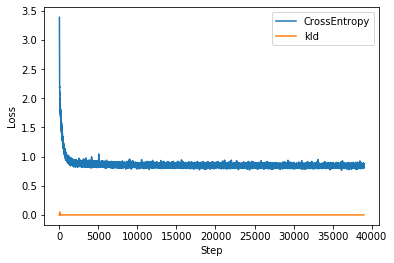

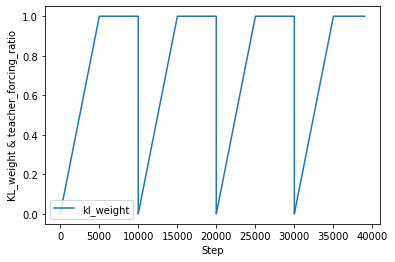

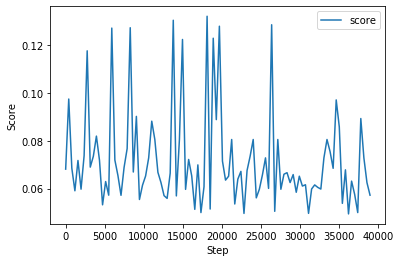

In [12]:
plt.figure()

load = True
if load:
    acc = np.load(loss_file)
    entropy = acc['entropy']
    kld = acc['kld']
    kl_weight = acc['kl_weight']
    teacher_forcing_ratio = acc['teacher_forcing_ratio']
    score = acc['score']
    
# plt.title("Activation Function comparision(EEGNet)")
plt.ylabel("Loss")
plt.xlabel("Step")
# print(test_loss)
x = np.arange(1, len(entropy)+1)
plt.plot(x, entropy, label="CrossEntropy")
plt.plot(x, kld, label="kld")
plt.legend()
plt.show()
plt.clf()

plt.ylabel("KL_weight & teacher_forcing_ratio")
plt.xlabel("Step")
# print(test_loss)
x = np.arange(1, len(kl_weight)+1)
plt.plot(x, kl_weight, label="kl_weight")
# plt.plot(x, teacher_forcing_ratio, label="teacher_forcing_ratio")
# plt.plot(x, test_loss, label="test")
plt.legend()
plt.show()

plt.ylabel("Score")
plt.xlabel("Step")
# print(test_loss)
x = np.linspace(1, len(kl_weight)+1, len(score))
plt.plot(x, score, label="score")
# plt.plot(x, test_loss, label="test")
plt.legend()
plt.show()


In [16]:
def reparaterization_trick(mean, logv):
        std = torch.exp(0.5*logv)
        eps = torch.randn_like(std)
        return  mean + eps * std
    
def Gaussian_score(words):
    words_list = []
    score = 0
    yourpath = './train.txt'#should be your directory of train.txt
    with open(yourpath,'r') as fp:
        for line in fp:
            word = line.split(' ')
            word[3] = word[3].strip('\n')
            words_list.extend([word])
        for t in words:
            for i in words_list:
                if t == i:
                    score += 1
    return score/len(words)

    
label = torch.LongTensor([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, 1]]).to(device)

words = []
for i in range(100):
    hidden_mean = torch.randn([1, 1, 32]).to(device)
    hidden_logv = torch.randn([1, 1, 32]).to(device)
    cell_mean = torch.randn([1, 1, 32]).to(device)
    cell_logv = torch.randn([1, 1, 32]).to(device)
    
    encoder_hidden = reparaterization_trick(hidden_mean, hidden_logv)
    encoder_hidden = decoder.latent2hidden(encoder_hidden)
    encoder_cell = reparaterization_trick(cell_mean, cell_logv)
    encoder_cell = decoder.latent2hidden(encoder_cell)
    
    tmp = []
    for i in range(4):
        hidden = torch.cat([encoder_hidden, label[i].view(1, 1, 4)], dim=2)
        cell = torch.cat([encoder_cell, label[i].view(1, 1, 4)], dim=2)
        decoded_indices = decoder.evaluate(context_vector=hidden, decoder_cell=cell)
        results = []
        for indices in decoded_indices:
            results.append(train_loader.vocab.indices_to_sequence(indices))
        tmp.append(results[0])
    words.append(tmp)
print(words)
print("Total Gaussion score:", Gaussian_score(words))

[['survive', 'survives', 'surviving', 'survived'], ['survive', 'survives', 'surviving', 'survived'], ['survive', 'survives', 'surviving', 'survived'], ['survive', 'survives', 'surviving', 'survived'], ['speculate', 'speculates', 'speculating', 'sprayed'], ['survive', 'survives', 'surviving', 'survived'], ['survive', 'survives', 'surviving', 'survived'], ['survive', 'survives', 'surviving', 'survived'], ['survive', 'survives', 'surviving', 'survived'], ['survive', 'survives', 'surviving', 'survived'], ['survive', 'survives', 'surviving', 'survived'], ['survive', 'survives', 'surviving', 'survived'], ['survive', 'survives', 'surviving', 'survived'], ['survive', 'survives', 'surviving', 'survived'], ['survive', 'survives', 'surviving', 'survived'], ['survive', 'survives', 'surviving', 'survived'], ['survive', 'survives', 'surviving', 'survived'], ['survive', 'survives', 'surviving', 'survived'], ['survive', 'survives', 'surviving', 'survived'], ['survive', 'survives', 'surviving', 'surviv

In [15]:
total_score = 0.0
for i in range(len(test_src)):
    word = train_loader.vocab.indices_to_sequence(test_src[i])
    trg_true = train_loader.vocab.indices_to_sequence(test_trg[i])
    results = trainer.evaluate(word, test_c_src[i].view(1, -1), test_c_trg[i].view(1, -1))[0]
    score = trainer.compute_bleu(results, trg_true)
    print("Src_true: {:>12}".format(word), "\tTrg_true:{:>12}".format(trg_true), "\tPredict: {:>12}".format(results), "\tScore: {:>8.5f}".format(score))
    total_score += score
total_score /= len(test_src)
print(total_score)

Src_true:      abandon 	Trg_true:   abandoned 	Predict:     survived 	Score:  0.05184
Src_true:         abet 	Trg_true:    abetting 	Predict:    surviving 	Score:  0.11868
Src_true:        begin 	Trg_true:      begins 	Predict:     survives 	Score:  0.03656
Src_true:       expend 	Trg_true:     expends 	Predict:     survives 	Score:  0.03303
Src_true:         sent 	Trg_true:       sends 	Predict:     survives 	Score:  0.03656
Src_true:        split 	Trg_true:   splitting 	Predict:    surviving 	Score:  0.13485
Src_true:       flared 	Trg_true:       flare 	Predict:      survive 	Score:  0.03928
Src_true:  functioning 	Trg_true:    function 	Predict:      survive 	Score:  0.03405
Src_true:  functioning 	Trg_true:  functioned 	Predict:     survived 	Score:  0.05440
Src_true:      healing 	Trg_true:       heals 	Predict:     survives 	Score:  0.03303
0.05722825182248287
